<a href="https://colab.research.google.com/github/StratosFair/DNN_Classifiers_Fast_Rates/blob/main/fashion_mnist_tshirt_pullover_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fashion-MNIST Classes
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Define transforms to convert images into tensors
fashion_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Fashion-MNIST dataset
fashion_train = datasets.FashionMNIST(root="./data", train=True, download=True, transform=fashion_transform)
fashion_test = datasets.FashionMNIST(root="./data", train=False, download=True, transform=fashion_transform)

# Filter for T-shirt/top (class 0) and Pullover (class 2)
indices_tshirt = [i for i, (_, label) in enumerate(fashion_train) if label == 0]
indices_pullover = [i for i, (_, label) in enumerate(fashion_train) if label == 2]

# Combine indices
train_indices = indices_tshirt + indices_pullover
test_indices = [i for i, (_, label) in enumerate(fashion_test) if label in [0, 2]]

# Create train and test subsets
train_data = Subset(fashion_train, train_indices)
test_data = Subset(fashion_test, test_indices)

# Assign labels: Pullover -> +1, T-shirt/top -> -1
def assign_labels(subset):
    images, labels = zip(*[(data[0], 1.0 if data[1] == 2 else -1.0) for data in subset])
    return torch.stack(images), torch.tensor(labels)

# Assign labels to train and test datasets
X_train, y_train = assign_labels(train_data)
X_test, y_test = assign_labels(test_data)

# Verify data shapes
print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 301kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.56MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.91MB/s]


Train data shape: torch.Size([12000, 1, 28, 28]), Train labels shape: torch.Size([12000])
Test data shape: torch.Size([2000, 1, 28, 28]), Test labels shape: torch.Size([2000])


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.network = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 1 input channel for grayscale images
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Fully connected layers
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),  # Adjust dimensions for 28x28 images
            nn.ReLU(),
            nn.Linear(128, 1)  # Outputs a scalar value (-1 to 1)
        )

    def forward(self, x):
        return self.network(x)

In [4]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = SimpleCNN()
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the loss threshold
loss_threshold = 0.03

# Training loop with early stopping
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # Forward pass
        outputs = model(images).squeeze()  # Output shape: [batch_size]
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)

    # Print progress
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Check if loss is below the threshold
    if avg_loss < loss_threshold:
        print(f"Stopping early at epoch {epoch+1} as loss fell below {loss_threshold:.4f}")
        break

Epoch 1/100, Loss: 0.1747
Epoch 2/100, Loss: 0.1007
Epoch 3/100, Loss: 0.0905
Epoch 4/100, Loss: 0.0853
Epoch 5/100, Loss: 0.0811
Epoch 6/100, Loss: 0.0744
Epoch 7/100, Loss: 0.0730
Epoch 8/100, Loss: 0.0684
Epoch 9/100, Loss: 0.0648
Epoch 10/100, Loss: 0.0604
Epoch 11/100, Loss: 0.0584
Epoch 12/100, Loss: 0.0545
Epoch 13/100, Loss: 0.0513
Epoch 14/100, Loss: 0.0494
Epoch 15/100, Loss: 0.0471
Epoch 16/100, Loss: 0.0451
Epoch 17/100, Loss: 0.0414
Epoch 18/100, Loss: 0.0396
Epoch 19/100, Loss: 0.0366
Epoch 20/100, Loss: 0.0360
Epoch 21/100, Loss: 0.0333
Epoch 22/100, Loss: 0.0296
Stopping early at epoch 22 as loss fell below 0.0300


In [5]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = []
    for images, _ in test_loader:
        outputs = model(images).squeeze()  # Predicted values (-1 to 1)
        y_pred.extend(outputs.tolist())

# Convert predictions to numpy array for histogram
y_pred = np.array(y_pred)

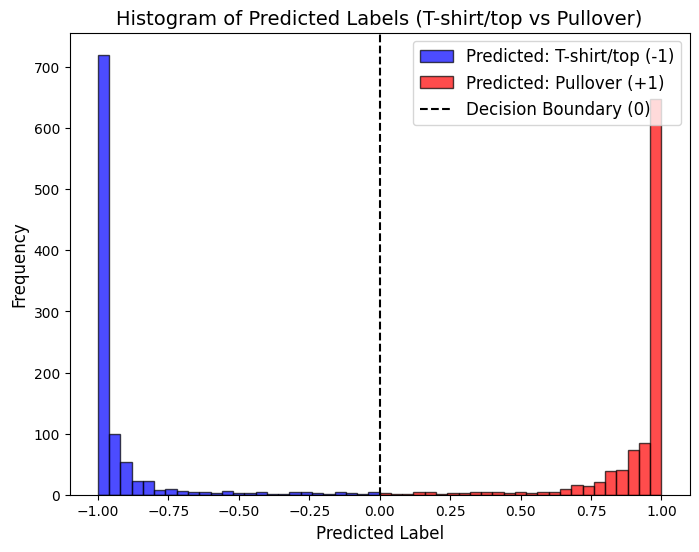

In [6]:
# Clip predictions to [-1, 1]
y_pred = np.clip(y_pred, -1, 1)

# Plot histogram
plt.figure(figsize=(8, 6))
bins = np.linspace(-1, 1, 51)  # 50 bins between -1 and 1
plt.hist(y_pred[y_pred < 0], bins=bins, alpha=0.7, color='blue', edgecolor='black', label='Predicted: T-shirt/top (-1)')
plt.hist(y_pred[y_pred > 0], bins=bins, alpha=0.7, color='red', edgecolor='black', label='Predicted: Pullover (+1)')
plt.axvline(0, color='black', linestyle='--', label='Decision Boundary (0)')

# Add labels and title
plt.title("Histogram of Predicted Labels (T-shirt/top vs Pullover)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=12)
plt.show()